Author: Guy Azran  
E-mail: [guy.azran@campus.technion.ac.il](mailto:guy.azran@campus.technion.ac.il)

# Imitation Learning

<img src='https://upload.wikimedia.org/wikipedia/commons/1/1f/Makak_neonatal_imitation.png?1648499532601' width=1000/>

<a id="section:intro"></a>

# Introduction
Imitation Learning (IL) is a technique for learning a policy from demonstrations produced by an "expert" (in most cases, a human). There are several types of imitation learning methods, but the simplest approach is called Behavior Cloning (BC). In BC, we attempt to learn a classifier (or regressor if actions are continuous) where the feature space $\mathcal{X}$ is some representation of the state and the label set $\mathcal{Y}$ is the set of actions. The expert provides a "correct" action for a sample set of states by running in the environment and recording the actions taken at each state. This data is used to learn a classifier that predicts what action the expert would have taken at each state.

In this notebook, we present the BC method and implement an example on the [gym taxi environment](https://gym.openai.com/envs/Taxi-v3/). Our expert will be an A* algorithm with an admissible heuristic (ensuring optimality). We will then learn from the collected expert data using a multi-layer perceptron neural network, implemented in pytorch.

Recommended Lecture on IL: [Part 1](https://www.youtube.com/watch?v=kGc8jOy5_zY), [Part 2](https://www.youtube.com/watch?v=06uB13C5pxw), [Part 3](https://www.youtube.com/watch?v=a5wkzPa4fO4)

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import itertools

from collections import deque

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch

from AI_agents.Environments.gym_problem import GymProblem
from AI_agents.Search.best_first_search import a_star
from pettingzoo.mpe import simple_v2
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

from il_utils.dataset import ImitationLearningDataset
from il_utils.model import MLP
from il_utils.training import train_torch_model_sgd
from common.evaluation import evaluate_policy
from common.ipython_vis import animate_policy
from common.mpe_physics import PhysicsUtils
from common.pz_utils import SingleAgentParallelEnvGymWrapper


# initialize taxi env
taxi_env = gym.make("Taxi-v3").env
taxi_env.reset()

# constants for taxi env planning
PASSENGER_IN_TAXI = 4  # passenger idx when in taxi
LOCS = taxi_env.unwrapped.locs  # environment locations

# initialize MPE env
mpe_simple_env = simple_v2.parallel_env(continuous_actions=True)
mpe_simple_env = SingleAgentParallelEnvGymWrapper(mpe_simple_env)  # make gym compatible

# random seed
SEED = 42

# The problem

We model the world as an MDP where the state space is the set of all possible environment configurations, and the action space is the list of actions the taxi agent can execute within the environment. A possible configuration is any combination of taxi location, passenger location (including "in_taxi" indication), and the destination location. The domain map is 5x5, the passenger and destination can be one of 4 possible locations, and the passenger can be either in the taxi or at the initial destination, adding up to a total of $5\cdot 5\cdot 5\cdot 4 = 500$ states. This makes the taxi environment learnable via deterministic planning and state-value function estimation algorithms. Nevertheless, we are going to ignore the MDP model completely, and only use its notations to collect data using an expert policy.

# The expert

As mentioned in the [introduction](#section:intro), the expert is an implementation of the A* algorithm for this environment. [AI_agents](https://github.com/sarah-keren/AI_agents) is a library in production that provides generalized search algorithms and supports the taxi environment. The environment is wrapped as a custom `Problem` object that can be solved using A*.

In [2]:
taxi_problem = GymProblem(taxi_env, taxi_env.unwrapped.s)
taxi_problem.__class__.__bases__

(AI_agents.Search.problem.Problem,)

A* requires an admissible heuristic if we want to guarantee optimality. Below we define the following heuristic:
* if the passenger is in the taxi, calculate the Manhatten distance between the taxi and the destination and add 1 for the dropoff action
* if the passenger is not in the taxi, calculate the Manhatten distances between the taxi and the passenger, and between the passenger and the destination. Add 2 for the pickup and dropoff actions.

In [3]:
def manhatten_dist(r1, c1, r2, c2):
    # calssic manhatten dist |row1 - row2| + |col1 - col2|
    return abs(r1 - r2) + abs(c1 - c2)

def taxi_heuristic(node):
    # decode state integer to interpretable values
    taxi_row, taxi_col, passenger_idx, dest_idx = taxi_env.decode(node.state.get_key())

    # split to 2 cases where the passenger is in the taxi and not in the taxi.
    if passenger_idx == PASSENGER_IN_TAXI:
        # dist from the taxi to the destination
        return manhatten_dist(taxi_row, taxi_col, *LOCS[dest_idx]) + 1  # include dropoff
    elif passenger_idx == dest_idx:
        # passenger has reached the destination. this is a goal state
        return 0
    else:
        # dist from the taxi to the passenger and from the passenger to the destination
        passenger_dist = manhatten_dist(taxi_row, taxi_col, *LOCS[passenger_idx])
        dest_dist = manhatten_dist(*LOCS[passenger_idx], *LOCS[dest_idx])
        return passenger_dist + dest_dist + 2  # include pickup and dropoff actions

A planner policy simply takes an observation and makes a plan. While there are still acitons in that plan, yield the next action in the plan. Otherwise, start a new plan.

In [4]:
class TaxiAStarPolicy:
    def __init__(self, heuristic):
        self.heuristic = heuristic

        # a container for the plan actions.
        self.cur_plan = deque()

    def __call__(self, obs):
        # if out of actions (finished previous plan), or if observation is not in current plan,
        # create a new plan.
        if not self.cur_plan or self.cur_plan[0][0] != obs:
            # refresh the problem with a new initial state
            taxi_prob = GymProblem(taxi_env, taxi_env.unwrapped.s)

            # find the solution with the A* algorithm
            _, node, sol, _, _ = a_star(taxi_prob, heuristic_func=self.heuristic)

            # get a list of expected states
            state_lst = []
            while node.parent:
                node = node.parent
                state_lst.append(node.state.key)
            state_lst = reversed(state_lst)

            # save the plan for later extraction
            # a plan is a tuple of expected observations and the corresponding expert action
            self.cur_plan = deque(list(zip(state_lst, map(int, sol))))

        # pop the next action
        return self.cur_plan.popleft()[1]

taxi_expert = TaxiAStarPolicy(taxi_heuristic)

Let's see how our policy performs

In [5]:
# This code can be terminated early with an interruption
animate_policy(taxi_env, taxi_expert, episode_limit=10)

num episodes completed:   10
total rewards:            79
mean rewards per episode: 7.90


As we can see, we can use planning to define a perfect policy for this domain that solves the problem in real time. This will be our expert with whom we will collect our demonstration data.

# Trajectories

Given an initial state $s$ and a policy $\pi$, a **trajectory** (in a deterministic environment) is a collection of state action pairs $((s_1, a_1), ..., (s_n, a_n))$ where $s_1=s$, $a_i = \pi(s_i)$, and $s_{i+1}=P(s_i, a_i)$. In other words, a trajectory is an ordered collection of states and actions as experienced by running policy $\pi$ starting from state $s$.



In [6]:
# trajectory struct
class Trajectory:
    def __init__(self, observations=None, actions=None):
        self.observations = observations or []
        self.actions = actions or []

    def add_step(self, observation, action):
        self.observations.append(observation)
        self.actions.append(action)

    def __str__(self):
        return 'trajectory: ' + str(list(zip(self.observations, self.actions)))

    def __repr__(self):
        return str(self)

We can collect trajectories with our expert by simply recording the observations and the actions taken at these observations

In [7]:
def get_trajectory(env, policy, max_trajectory_length=float('inf')):
    # init trajectory object
    trajectory = Trajectory()

    # get first observation
    obs = env.reset()

    # iterate and step in environment.
    # limit num actions for incomplete policies
    for i in itertools.count(start=1):
        action = policy(obs)
        trajectory.add_step(obs, action)
        obs, reward, done, info = env.step(action)

        if done or i >= max_trajectory_length:
            break

    return trajectory

trajectory = get_trajectory(taxi_env, taxi_expert)
trajectory

trajectory: [(123, 1), (23, 3), (3, 4), (19, 2), (39, 0), (139, 0), (239, 2), (259, 2), (279, 0), (379, 0), (479, 5)]

# Data collection and preparation

We will now collect the data with which we will train simply by collecting multiple trajectories. As with most supervised learning settings, we will collect 3 datasets: training, validation, and testing. Since this is a relatively simple environment with a small number of states, we will collect a small number of trajectories so we do not encounter the entire state space in training. This way, we can see if our model is generalizing to new, unseen states.

In [8]:
def collect_data(env, policy, num_trajectories, max_trajectory_length=float('inf')):
    trajectories = []
    for _ in tqdm(range(num_trajectories)):
        trajectories.append(get_trajectory(env, policy, max_trajectory_length))

    return trajectories

# get the same trajectories every time!
taxi_env.seed(SEED)

taxi_raw_train_data = collect_data(taxi_env, taxi_expert, num_trajectories=400)
taxi_raw_val_data = collect_data(taxi_env, taxi_expert, num_trajectories=250)
taxi_raw_test_data = collect_data(taxi_env, taxi_expert, num_trajectories=250)

# show the first 5 training trajectories
taxi_raw_train_data[:5]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

[trajectory: [(386, 1), (286, 1), (186, 1), (86, 4), (98, 3), (78, 3), (58, 0), (158, 0), (258, 3), (238, 3), (218, 0), (318, 0), (418, 5)],
 trajectory: [(222, 1), (122, 1), (22, 3), (2, 4), (18, 0), (118, 0), (218, 0), (318, 0), (418, 5)],
 trajectory: [(387, 1), (287, 1), (187, 1), (87, 4), (99, 3), (79, 0), (179, 0), (279, 0), (379, 0), (479, 5)],
 trajectory: [(91, 3), (71, 3), (51, 0), (151, 0), (251, 3), (231, 3), (211, 0), (311, 0), (411, 4), (419, 1), (319, 1), (219, 2), (239, 2), (259, 2), (279, 0), (379, 0), (479, 5)],
 trajectory: [(329, 1), (229, 3), (209, 0), (309, 0), (409, 4), (417, 1), (317, 1), (217, 2), (237, 2), (257, 1), (157, 1), (57, 2), (77, 2), (97, 5)]]

The taxi environment's states are simply integers. This type of input is not very informative for supervised learning algorithms. A state's bits can be decomposed into the state attributes. We must use these attributes to create a good representation for the learning algorithm. The preprocessing function below represents the state as a vector of the taxi location, the passenger location, the destination location, and an indicator of whether the passenger is in the taxi.

In [9]:
def prep_taxi_state(state):
    # decompose state bits
    taxi_row, taxi_col, passenger_idx, destination_idx = taxi_env.decode(state)

    # get destination true location coordinates
    destination_row, destination_col = LOCS[destination_idx]

    # get passenger true location coordinates
    # add `in_taxi` indicator bit
    if passenger_idx == PASSENGER_IN_TAXI:
        passenger_row, passenger_col = taxi_row, taxi_col
        passenger_in_taxi = 1
    else:
        passenger_row, passenger_col = LOCS[passenger_idx]
        passenger_in_taxi = 0

    # return all data as a flat Tensor object for pytorch compatibility
    return torch.Tensor([taxi_row,
                         taxi_col,
                         passenger_row,
                         passenger_col,
                         passenger_in_taxi,
                         destination_row,
                         destination_col])

We can package the trajectories and preprocessing function into a single `Dataset` object. For this, we implement the `ImitationLearningDataset`, which unwraps the trajectories and keeps only the state-action pairs required for supervised learning. The dataset preprocess the states when requested. Note that we do **NOT** remove duplicates. This is to maintain the true trajectory sample distribution of the expert policy. The dataset is compatible with DataLoaders used to batch the data.

In [10]:
taxi_ds_train = ImitationLearningDataset(taxi_raw_train_data, prep_obs=prep_taxi_state)
taxi_ds_val = ImitationLearningDataset(taxi_raw_val_data, prep_obs=prep_taxi_state)
taxi_ds_test = ImitationLearningDataset(taxi_raw_test_data, prep_obs=prep_taxi_state)

taxi_ds_train[0]

(tensor([3., 4., 0., 4., 0., 4., 0.]), 1)

# Learning model

The learning model we will be using is the [multi-layer perceptron](https://www.sciencedirect.com/topics/computer-science/multilayer-perceptron#:~:text=Multi%20layer%20perceptron%20(MLP)%20is,input%20signal%20to%20be%20processed.) (MLP). This was one of the first neural network architectures. It uses multiple fully connected linear layers separated by non-linear activation functions ([ReLU](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/) in our case). MLP's excell at finding statistical correlations in vector data that is strongly ordered and real valued, especially if these corelations are continuous or near-continuous. Since our state representation matches this description, we expect the MLP model to handle this task with aplomb.

In [11]:
# get the input vector length from a training example
in_features = len(taxi_ds_train[0][0])

# The output vector length is the number of actions
num_actions = taxi_env.action_space.n

# seed to always get the same model parameter initialization
torch.manual_seed(SEED)

# create MLP model with 3 hidden layers
mlp_taxi = MLP(in_features=in_features, hidden_dims=[32, 64, 128], out_features=num_actions)
mlp_taxi

MLP(
  (fc_layers): Sequential(
    (0): Linear(in_features=7, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=6, bias=True)
  )
)

# Training

We will train the classifier with [stochastic gradient descent](https://towardsdatascience.com/stochastic-gradient-descent-clearly-explained-53d239905d31) optimization. We train using the Cross-Entropy loss which punishes the classifier for giving low scores to the true classes and higher scores to wrong classes (reminder, in this case a class is an action).

In [12]:
(train_losses,
 val_losses,
 train_accs,
 val_accs) = train_torch_model_sgd(model=mlp_taxi,
                                   ds_train=taxi_ds_train,
                                   ds_val=taxi_ds_val,
                                   loss_fn=torch.nn.CrossEntropyLoss(),
                                   batch_size=16,
                                   shuffle_data=True,
                                   num_epochs=200,
                                   learning_rate=1e-2,
                                   weight_decay=1e-5,
                                   print_every=10,
                                   include_accs=True,
                                   seed=SEED)

epoch 10:
avg training loss       = 0.7415909432893828
avg validation loss     = 0.6625609495290896
training acc            = 0.7384030418250951
validation acc          = 0.7738095238095238
timestamp: 02:03:48.088352

epoch 20:
avg training loss       = 0.22372974528956557
avg validation loss     = 0.20323084589184784
training acc            = 0.9309885931558936
validation acc          = 0.9355921855921856
timestamp: 02:03:51.305386

epoch 30:
avg training loss       = 0.10380267806770138
avg validation loss     = 0.09135746266920029
training acc            = 0.9678707224334601
validation acc          = 0.9713064713064713
timestamp: 02:03:54.603609

epoch 40:
avg training loss       = 0.059762057920459286
avg validation loss     = 0.05956391345982145
training acc            = 0.9857414448669202
validation acc          = 0.9856532356532357
timestamp: 02:03:57.957689

epoch 50:
avg training loss       = 0.03883942080262516
avg validation loss     = 0.032670291512068815
training acc      

Now let us visualize the results

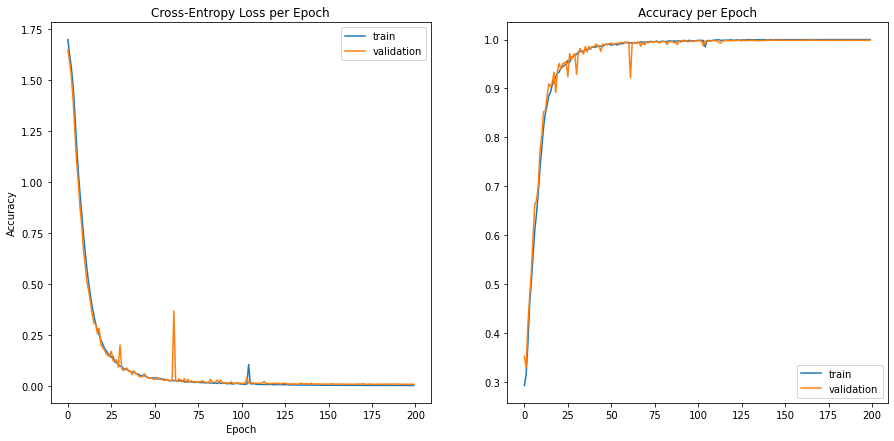

In [13]:
# plot 1x2 figure grid
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# plot losses
ax1.set_title('Cross-Entropy Loss per Epoch')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Cross-Entropy Loss')
ax1.plot(train_losses, label='train')
ax1.plot(val_losses, label='validation')
ax1.legend()

# plot accuracies
ax2.set_title('Accuracy per Epoch')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax2.plot(train_accs, label='train')
ax2.plot(val_accs, label='validation')
ax2.legend();

We see a relatiely short and stable training process. Seemingly, our learning algorithm is able to clone the expert's behavior almost perfectly. Below are the final accuracies of our model on our datasets.

In [14]:
def ds_acc(ds, model):
    # get the entire dataset at once.
    # this is will cause memory issues with large datasets
    ds_data, ds_labels = next(iter(DataLoader(ds, batch_size=len(ds))))

    # run get model predictions
    model.eval()
    with torch.no_grad():
        ds_preds = model(ds_data)

    # calculate prediction accuracies
    return torch.mean((torch.argmax(ds_preds, dim=-1) == ds_labels).float()).item()

# print test set accuracy
print(f'train acc      = {ds_acc(taxi_ds_train, mlp_taxi)}')
print(f'validation acc = {ds_acc(taxi_ds_val, mlp_taxi)}')
print(f'test acc       = {ds_acc(taxi_ds_test, mlp_taxi)}')

train acc      = 1.0
validation acc = 0.9987789988517761
test acc       = 0.9978671669960022


The above reults are considered to be excellent results in classification tasks, surpassing human annotators. Does this mean we have an excellent policy? What happens when a predicted action is not optimal? Can our agent recover from such mistakes?

# Evaluating the policy

Our newly trained classifier can be used as a policy for the taxi environment. With every input observation, the classifier gives each action a score. The action that was scored the highest is the one returned by the policy.

In [15]:
class ClassifierPolicy:
    def __init__(self, model, prep_fn=None):
        self.model = model

        # if no preprocessing function is given, use the identity function
        if prep_fn is None:
            self.prep_fn = lambda x: x
        else:
            self.prep_fn = prep_fn

    def __call__(self, observation):
        # preprocess observation
        prepped_obs = self.prep_fn(observation)
        one_obs_batch = prepped_obs[None]  # convert to batch of size 1

        # run model to get action scores
        self.model.eval()
        with torch.no_grad():
            batch_scores = self.model(one_obs_batch)

        # get scores for single observation
        obs_score = batch_scores[0]

        # choose the action with the highest score
        return torch.argmax(obs_score).item()

# create a policy driven by the MLP model that uses the same observation preprocessing
# function as in training
taxi_il_policy = ClassifierPolicy(mlp_taxi, prep_fn=taxi_ds_train.prep_obs)

## How good is can an immitation policy be?

Let us compare the performance of the expert policy and the classifier policy

In [16]:
total_reward, mean_reward = evaluate_policy(taxi_env, taxi_expert, num_episodes=10_000,
                                            seed=SEED)
print('A* Policy')
print('---------')
print(f'total reward over all episodes: {total_reward}')
print(f'mean reward per episode:        {mean_reward}')

  0%|          | 0/10000 [00:00<?, ?it/s]

A* Policy
---------
total reward over all episodes: 77458
mean reward per episode:        7.7458


In [17]:
total_reward, mean_reward = evaluate_policy(taxi_env, taxi_il_policy, num_episodes=10_000, seed=SEED)
print('Classifier Policy')
print('-----------------')
print(f'total reward over all episodes: {total_reward}')
print(f'mean reward per episode:        {mean_reward}')

  0%|          | 0/10000 [00:00<?, ?it/s]

Classifier Policy
-----------------
total reward over all episodes: 75359
mean reward per episode:        7.5359


We note that, in expectation, our imitation policy performs almost as well as the expert. Sadly, this is not the only measure of a policy.

## Imitation learning failures

Like we did before, let us see our policy in action

In [18]:
# This code can be terminated early with an interruption
animate_policy(taxi_env, taxi_il_policy, episode_limit=10)

num episodes completed:   10
total rewards:            88
mean rewards per episode: 8.80


In the vast majority of cases, our policy acts identically to the optimal A* policy. However, during the above animation, you may have seen the policy fail miserably in one or more starting position. Let us recreate one such a scenario.

In [19]:
# reset env
taxi_env.reset()

# set current state to be the failure state
failure_obs = taxi_env.encode(3, 0, 3, 2)
taxi_env.unwrapped.s = failure_obs

# step using
failure_action = taxi_il_policy(failure_obs)
taxi_env.step(failure_action)

# render the environment
taxi_env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)


As we can see, the taxi should go North on its way to location B to pick up the passenger. However, our classifier policy chooses to go East, thus crashing into the wall. Worse yet, as long as the episode is live, the state will remain the same and our policy will choose the same action over and over. In a real-world situation, we could not afford to repeatedly crash a car into the wall. Obviously, our expert can solve this problem with ease, but our clasifier is unable to generalize. This kind of failure is caused by two phenomena, discussed below.

### Distributional shift

<img src="https://futureoflife.org/wp-content/uploads/2019/06/distributional-shift.png"/>

In the classification problem, we assume our finite sample set $S\subset \mathcal{X}\times \mathcal{Y}$ was sampled I.I.D. from some distribution $D$. In reality, the sample set is a collection of trajectories sampled from distribution $D_{\pi_{\text{expert}}}$ that is dependent on the expert policy. When deploying our algorithm, we sample data from $D_{\pi}$ that is dependant on our policy $\pi$. However, unless  $\pi_{\text{expert}} = \pi$, then $D_{\pi_{\text{expert}}} \neq D_{\pi}$, and so incoming data is sampled from outside the expected distribution.

When the agent observes a previously unseen state, it may act differently from the expert. When this happens, the next observation is sampled from $D_\pi$ and not $D_{\pi_{\text{expert}}}$, on which our agent is even more likely to make a mistake. This issue compounds as the distribution of the samples "shifts" from $D_{\pi_{\text{expert}}}$ to $D_\pi$.

Distributional shift is hard to demonstrate on the single taxi domain due to its simplicity. In the above example, the taxi begins from an unseen state (we know it is unseen because the training accuracy is 1). Since the policy's failure leaves the state unchanged, the distribution has nowhere to shift.

One interesting solution to distributional shift is [DAGGER](https://www.cs.cmu.edu/~sross1/publications/Ross-AIStats11-NoRegret.pdf) (Dataset Aggregation). In DAGGER, the aim is to try to converge $\pi_{\text{expert}}$ to $\pi$ via an iterative algorithm. The working assumption is that if $\pi_{\text{expert}} \sim \pi$ then $D_{\pi_{\text{expert}}} \sim D_{\pi}$. The idea is to perform behavior cloning, deploy the policy to collect more data, and then have an expert annotate the observations with the correct action. The new data is added to the old data and the process starts over. The most glaring issue with this technique is the need for a human annotator, which can be very expensive or simply unsafe. This kind of imitation learning is called policy aggregation.


### The Markov assumption

We previously noticed that in the above example, our taxi continuously chooses the East action, casuing it to hit the wall and remain in place. Why does the agent not realize this action is not helping it advance toward the goal? This is due to the ***Markovian assumption***. Under it, the next state is determined only by the current state and action, regardless of any previous states visited or actions taken. In other words, our MDP model does account for any memory of the past. Specifically, the agent has no recollection of hitting the wall, and so it has no access to information that could hint to East being a bad action.

Remember that after training, neural networks are nothing more than functions. In our case, we have a deterministic model, i.e., for any observation $s$, $\pi(s)$ will always yield the same output. Since our model parameters will no longer change, we cannot hope to surpass this problem state. To break the Markov assumption, it is customary to use recurrent neural networks which have a built-in memory mechanism in the form of hidden states.

# Conclusion

IL, and specifically BC, is a simple solution to solving basic RL problems. Although it is not perfect, it can achieve some impressive results in expectation. However, we notice two massive issues that manage to cripple even as simple a domain as single-taxi.

Our learner is unable to generalize to unseen states and so one mistake can lead to complete failure. A straight forward solution is to collect more data. Due to the small number of states, we will most likely collect optimal actions for all possible states if we collect enough trajectories. Our deep classifier is able to completely fit the training data, and so in this case our classifier correctly chooses the optimal action (as would the expert) at every state.

The above solution is only relevant for a simple domain such as this, and is not feasible in much larger state spaces or continuous spaces, in which our algorithms must be able to generalize to unseen observations if they are to be useful. If that is the case, then a planning algorithm such as A* is far more practical than BC or any other learning algorithm.

There are other forms of imitation learning (see [this blog bost](https://smartlabai.medium.com/a-brief-overview-of-imitation-learning-8a8a75c44a9c)) besides BC that were not discussed in this presentation. These techniques are aimed at solving issues in BC.

# Continuous Space Imitation Learning

We now present imitation learning in the case of continuous observation and action spaces. For this we use the [MPE Simple environment](https://www.pettingzoo.ml/mpe/simple), which is a 2d navigator environment where a single agent must reach a goal position in a continuous world.

There are two key differences between this example and the taxi example:
1. We cannot use A* as the expert due to the infinite state and action spaces.
2. Since the actions are continuous, we want to perform regression (not classification)

## Expert

To address the expert issue, we implement a navigation trajectory planning policy for this environment in which there are no obstacles into which the agent can collide, meaning we simply need the fastest route to the destination. Note that the shortest path might not be the fastest! Since the force cap is per axis and not a global magnitude of the force (i.e., the norm), then we can solve the problem for both axes separately and simultaneously. Our expert policy is defined as follows:
* for each axis:
    * if the agent is at the target (on the current axis)
        * if the agent can stop, then stop.
        * otherwise, full break in the opposite direction of the axis velocity.
    * if the agent can reach the target in the next step and then stop, apply the force required to reach the target.
    * if the agent can accelerate with maximal force and is still able to stop without overshooting the target, apply full force toward the target.
    * otherwise, apply full force away from the target (i.e., break)
* apply the force chosen force on each axis

To implement this policy, we wrote a physics utility that implements useful tools for handling the environment's world physics. This can be found under `common.mpe_physics.PhysicsUtils`.

A big thanks to [**Adi Amuzig**](https://www.linkedin.com/in/adiamuzig/) for formulating and solving the optimization problem on which this algorithm is based.

In [20]:
class NavigatorMaxAccelerationPolicy:
    def __init__(self, env):
        # physics utility
        self.__utils = PhysicsUtils(env)

    def __call__(self, obs):
        # extract axis velocity and target information
        v_target_cutoff = len(obs) // 2
        obs_v, obs_target = obs[:v_target_cutoff], obs[v_target_cutoff:]

        # find optimal force for each axis
        force_per_axix = [self.policy_1d(v, x) for v, x in zip(obs_v, obs_target)]

        # set the force as a valid action
        return np.concatenate([[0]] + [self.__force_to_action(f) for f in force_per_axix],
                              dtype=np.float32)

    def policy_1d(self, v, x_target):
        # currently on target
        if x_target == 0:
            if self.__utils.can_stop(v):  # can stop, then stop.
                return self.__utils.force_to_stop(v)
            else:  # can't stop, then break as hard as possible.
                return self.__utils.max_force_in_dir(-v)

        # target is reachable in one move and then stop is possible in the next, then do it.
        if self.__utils.two_moves_from_target(0, v, x_target):
            return self.__utils.force_to_target(0, v, x_target)

        # if full acceleration will not cause us to overshoot the target, accelerate.
        if self.__utils.can_full_accelerate(v, x_target):
            return self.__utils.max_force_in_dir(x_target)

        # push away from the target hoping that the agent won't overshoot.
        return self.__utils.max_force_in_dir(-x_target)

    def __force_to_action(self, f):
        # force applied as a separate value for positive and negative force.
        mag = abs(f)
        if f > 0:
            return np.array([mag, 0])
        else:
            return np.array([0, mag])

mpe_simple_expert = NavigatorMaxAccelerationPolicy(mpe_simple_env)

Thanks to the environment wrapper, all of our previous functions are compatible with all of our previous functions. Let us see the policy in action.

In [21]:
# This code can be terminated early with an interruption
animate_policy(mpe_simple_env, mpe_simple_expert, episode_limit=100, sleep=0)

num episodes completed:   100
total rewards:            -397.80526693972695
mean rewards per episode: -3.98


## Data Collection

We can also collect the data and package it exactly as we did for the taxi environment. Since the state space in this environment is larger, we will collect more trajectories. Keep in mind that each trajectories in this environment are far longer than those in the taxi environment.

In [22]:
mpe_simple_env.seed(SEED)
mpe_simple_raw_train_data = collect_data(mpe_simple_env, mpe_simple_expert,
                                         num_trajectories=1_000)
mpe_simple_raw_val_data = collect_data(mpe_simple_env, mpe_simple_expert,
                                       num_trajectories=200)
mpe_simple_raw_test_data = collect_data(mpe_simple_env, mpe_simple_expert,
                                        num_trajectories=200)

mpe_simple_ds_train = ImitationLearningDataset(mpe_simple_raw_train_data,
                                               prep_obs=torch.from_numpy,
                                               prep_action=torch.from_numpy)
mpe_simple_ds_val = ImitationLearningDataset(mpe_simple_raw_val_data,
                                             prep_obs=torch.from_numpy,
                                             prep_action=torch.from_numpy)
mpe_simple_ds_test = ImitationLearningDataset(mpe_simple_raw_test_data,
                                              prep_obs=torch.from_numpy,
                                              prep_action=torch.from_numpy)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

## Learning Model

This kind of environment where all the observations are continuous is perfect for MLP models. They tend to fit quickly and generalize well on such data, and so we will use a similar learning model to the one used in the taxi example.

However, we must remember that this is a multi-value regression problem. In regression, the target set $\mathcal{Y}$ is now a subset of $\mathbb{R}$ instead of a finite set of labels. In multi-value regression, we have $\mathcal{Y}\subseteq\mathbb{R}^n$ where $n$ is the number of real numbers we must estimate. In the case of our environment configuration, the values are between 0 and 1. To enforce this on our network's output, we add a [sigmoid activation](https://en.wikipedia.org/wiki/Sigmoid_function) (A.K.A. "expit" or "inverse logit") to the output layer. Note that for a different limit, we can just multiply the sigmoid output by this constant value and achieve the desired output constraint.

In [23]:
# get the input vector length from a training example
in_features = len(mpe_simple_ds_train[0][0])

# the output vector should be the size of an action vector
action_size = mpe_simple_env.action_space.shape[0]

# seed to always get the same model parameter initialization
torch.manual_seed(SEED)
mlp_mpe_simple = MLP(in_features=in_features, hidden_dims=[32, 64, 128],
                     out_features=action_size, output_activation=torch.nn.Sigmoid())
mlp_mpe_simple

MLP(
  (fc_layers): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=5, bias=True)
    (7): Sigmoid()
  )
)

## Training

To train the MLP network, we optimize the [mean absolute error](https://en.wikipedia.org/wiki/Mean_absolute_error) (MAE) loss, implmented in `torch.nn.L1Loss` and defined:
$$MSE(h, (X, Y)) = \frac{1}{|X|}\sum_{i=1}^m\sum_{j=1}^n(h(x_i)_j - y_{i,j})^2$$
where $h$ is the regression function, $h(x_i)_j$ is the $j$'th output of the regressor for input $x_i$, and $y_{i,j}$ is the $j$'th value of the $i$'th target vector.

In [24]:
train_losses, val_losses = train_torch_model_sgd(model=mlp_mpe_simple,
                                                 ds_train=mpe_simple_ds_train,
                                                 ds_val=mpe_simple_ds_val,
                                                 loss_fn=torch.nn.MSELoss(),
                                                 batch_size=32,
                                                 shuffle_data=True,
                                                 num_epochs=200,
                                                 learning_rate=1e-1,
                                                 weight_decay=0,
                                                 print_every=10,
                                                 include_accs=False,
                                                 seed=SEED)

epoch 10:
avg training loss       = 0.016590159201799223
avg validation loss     = 0.014842526567506658
timestamp: 02:07:04.523622

epoch 20:
avg training loss       = 0.010222604201646293
avg validation loss     = 0.009660319408852678
timestamp: 02:07:10.471345

epoch 30:
avg training loss       = 0.009623062330112933
avg validation loss     = 0.009371708475155636
timestamp: 02:07:17.010429

epoch 40:
avg training loss       = 0.00925452368395865
avg validation loss     = 0.009017583737624395
timestamp: 02:07:23.140492

epoch 50:
avg training loss       = 0.009020705469460447
avg validation loss     = 0.008961514181273568
timestamp: 02:07:29.245180

epoch 60:
avg training loss       = 0.008826102936220423
avg validation loss     = 0.008449703148824969
timestamp: 02:07:36.934545

epoch 70:
avg training loss       = 0.00870250749987993
avg validation loss     = 0.008665047660206777
timestamp: 02:07:46.311057

epoch 80:
avg training loss       = 0.008476666845203361
avg validation loss  

We can see a smoothe training curve indicating stable training and great generalization capabilities.

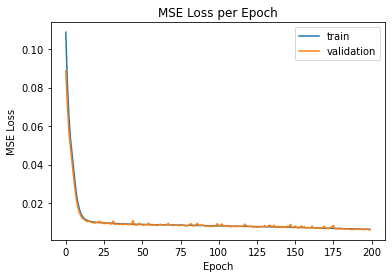

In [25]:
# plot losses
plt.title('MSE Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='validation')
plt.legend();

## Policy Evaluation

Our policy is identical to the classifier policy for the taxi environment, except that the outputs are the values for each entry in the action space vector.

In [26]:
class MultiRegressionPolicy:
    def __init__(self, model, prep_fn=None):
        self.model = model

        # if no preprocessing function is given, use the identity function
        if prep_fn is None:
            self.prep_fn = lambda x: x
        else:
            self.prep_fn = prep_fn

    def __call__(self, observation):
        # preprocess observation
        prepped_obs = self.prep_fn(observation)
        one_obs_batch = prepped_obs[None]  # convert to batch of size 1

        # run model to get action values
        self.model.eval()
        with torch.no_grad():
            batch_out = self.model(one_obs_batch)

        # get values for single observation
        obs_out = batch_out[0]

        # return continuous action
        return obs_out.numpy()

mpe_simple_il_policy = MultiRegressionPolicy(mlp_mpe_simple,
                                             prep_fn=mpe_simple_ds_train.prep_obs)


Now let us compare the expert policy to our newly created deep regression policy.

In [27]:
total_reward, mean_reward = evaluate_policy(mpe_simple_env, mpe_simple_expert,
                                            num_episodes=10_000, seed=SEED)
print('Max Acceleration per Axis Policy')
print('---------')
print(f'total reward over all episodes: {total_reward}')
print(f'mean reward per episode:        {mean_reward}')

  0%|          | 0/10000 [00:00<?, ?it/s]

Max Acceleration per Axis Policy
---------
total reward over all episodes: -43899.756110528026
mean reward per episode:        -4.389975611052803


In [28]:
total_reward, mean_reward = evaluate_policy(mpe_simple_env, mpe_simple_il_policy,
                                            num_episodes=10_000, seed=SEED)
print('Multi-Value Regression Policy')
print('-----------------')
print(f'total reward over all episodes: {total_reward}')
print(f'mean reward per episode:        {mean_reward}')

  0%|          | 0/10000 [00:00<?, ?it/s]

Multi-Value Regression Policy
-----------------
total reward over all episodes: -44620.60107545008
mean reward per episode:        -4.462060107545009


As we can see our model almost matches the expert's performance (in some runs the imitation learning model got better results than the expert!). This is also clear when seeing at the policy in action.

In [29]:
# This code can be terminated early with an interruption
animate_policy(mpe_simple_env, mpe_simple_il_policy, episode_limit=100, sleep=0.017)

num episodes completed:   100
total rewards:            -414.6161236566214
mean rewards per episode: -4.15


## Extending the Problem

It appears that the IL agent is able to mimic the expert almost perfectly (if not so). However, this is the simplest possible setting. It would be interesting to see how IL is affected by certain configuration changes. For example, adding just a small amount of noise could lead to severe distributional shift that can cause catastrophic failure.